# HW5: Ensemble methods and cross validation with college data

Using the college statistic data to compare different ensemble methods on their performance with cross validation.


In [0]:
# import few things we will use in this exercise
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.0MB/s 


In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'185gv_hzqVvSUI_TBDINYNU6Leawu5tMo'}) # replace the id with id of file you want to access
downloaded.GetContentFile('college.csv')

In [0]:
# read in the data and save it in a dataframe
col = pd.read_csv('college.csv')

In [0]:
# Take a look and see what's in it
col.head(10)

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
5,Albertson College,Yes,587,479,158,38,62,678,41,13500,3335,500,675,67,73,9.4,11,9727,55
6,Albertus Magnus College,Yes,353,340,103,17,45,416,230,13290,5720,500,1500,90,93,11.5,26,8861,63
7,Albion College,Yes,1899,1720,489,37,68,1594,32,13868,4826,450,850,89,100,13.7,37,11487,73
8,Albright College,Yes,1038,839,227,30,63,973,306,15595,4400,300,500,79,84,11.3,23,11644,80
9,Alderson-Broaddus College,Yes,582,498,172,21,44,799,78,10468,3380,660,1800,40,41,11.5,15,8991,52


---
## EDA: 
##### You may perform more EDA steps than the ones suggested below.

In [0]:
# See what kind of data format and how many are there in each column
col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
Unnamed: 0     777 non-null object
Private        777 non-null object
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(16), object(2)
memory usage: 115.4+ KB


---

#### Rename the first column name to University so it will be easier to relate.

In [0]:
#After renaming, check to see if the column names got changed.
col.rename(columns={'Unnamed: 0':'University'}, inplace=True)
col.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


#### Change yes/no to 1/0 in column 'Priviate' to get it ready for model training.

In [0]:
#First of all, find out how many yes and no are there in the 'Private' column.
col['Private'].value_counts()

Yes    565
No     212
Name: Private, dtype: int64

In [0]:
#change yes to 1 and no to 0 in the "Private" column and view the changes after your action.
col['Private'].replace({'Yes':1, 'No':0}, inplace=True)
col.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [0]:
#check to see if there are equal number of 1/0s as that in yes/no you checked earilier.
print (col['Private'].value_counts())
print ("\nYes there are equal number of 1/0s as that in yes/no.")

1    565
0    212
Name: Private, dtype: int64

Yes there are equal number of 1/0s as that in yes/no.


___
### Compare classification performance of different models with cross validation

In [0]:
# Assign the Private column as target y and 
#assign all columns, except University and Private, in the dataframe as X

y=col['Private']
X = col.iloc[:,2:]

### Testing the function on Decision Tree algorithm

In [0]:



def cross_score(model,model_name,n_splits, X, y):
    """
    Function that shows performance avearge and standard deviation 
    with different models and differnt number of splits in cross validation.

    Args:
        model: machine learning model used, e.g., DecisionTreeClassifier()
        model_name: The name of the machine learning model used, e.g., 'Decision Tree' Classifier.
        n_splits: number of folds used in StratifiedKFold
        X: feature data used for the model
        y: target data used for the model
    Returns:
        none
    Printout: 
        the average and the standard deviation of cross validation score 
        with 3 decimal places like the following.
        
        Decision Tree Classifier with 2 splits has an average score of 0.916 ± 0.038

    """
    ### your code here ###
  
    cvs = StratifiedKFold(n_splits, shuffle=True)
    s = cross_val_score(model, X, y, cv=cvs, n_jobs=-1)
    
    print("{} Classifier with {} splits has an average score of {:0.3} ± {:0.3}".format(model_name, n_splits, s.mean().round(3), s.std().round(3)))
   
    return 
  
    
    
  
    

In [0]:
cross_score(DecisionTreeClassifier(), "Decision Tree", 2, X, y)

Decision Tree Classifier with 2 splits has an average score of 0.903 ± 0.014


In [0]:
# show the  the average and the standard deviation of cross validation score 
#for splits ranging from 2 to 20


In [0]:
for i in range(2,21):
  cross_score(DecisionTreeClassifier(), "Decision Tree", i, X, y)

Decision Tree Classifier with 2 splits has an average score of 0.902 ± 0.01
Decision Tree Classifier with 3 splits has an average score of 0.892 ± 0.005
Decision Tree Classifier with 4 splits has an average score of 0.898 ± 0.02
Decision Tree Classifier with 5 splits has an average score of 0.902 ± 0.017
Decision Tree Classifier with 6 splits has an average score of 0.9 ± 0.011
Decision Tree Classifier with 7 splits has an average score of 0.914 ± 0.037
Decision Tree Classifier with 8 splits has an average score of 0.907 ± 0.029
Decision Tree Classifier with 9 splits has an average score of 0.893 ± 0.041
Decision Tree Classifier with 10 splits has an average score of 0.904 ± 0.022
Decision Tree Classifier with 11 splits has an average score of 0.904 ± 0.03
Decision Tree Classifier with 12 splits has an average score of 0.907 ± 0.033
Decision Tree Classifier with 13 splits has an average score of 0.903 ± 0.032
Decision Tree Classifier with 14 splits has an average score of 0.901 ± 0.044

#### By examining the result above, which split(s) gives you best performance?

Decision Tree Classifier with 7 splits gives the best performance, as it has the highest score.

___
### Comparing the mean and sd of cross validation scores subject to decision tree and ensemble methods

Use the function you created above to print out  
the mean and sd of cross validation scores for  
decision trees, bagging, random forest, extra trees ,
AdaBoost, and Gradient Boosting classifiers   
with 3 folds cross validation.

In [0]:
n=3


In [0]:
cross_score(DecisionTreeClassifier(), "Decision Tree", 3, X, y)

Decision Tree Classifier with 3 splits has an average score of 0.912 ± 0.007


In [0]:
cross_score(BaggingClassifier(), "Bagging", 3, X, y)

Bagging Classifier with 3 splits has an average score of 0.933 ± 0.013


In [0]:
cross_score(RandomForestClassifier(), "Random Forest", 3, X, y)

Random Forest Classifier with 3 splits has an average score of 0.933 ± 0.015


In [0]:
cross_score(ExtraTreesClassifier(), "Extra Trees", 3, X, y)

Extra Trees Classifier with 3 splits has an average score of 0.94 ± 0.017


In [0]:
cross_score(AdaBoostClassifier(), "Ada Boost", 3, X, y)

Ada Boost Classifier with 3 splits has an average score of 0.932 ± 0.014


In [0]:
cross_score(GradientBoostingClassifier(), "Gradient Boosting", 3, X, y)

Gradient Boosting Classifier with 3 splits has an average score of 0.947 ± 0.015


#### Comment on the mean and the sd deviation of scores and see if they are consistent with the pros and cons of ensemble methods.   
You may want to run few times for generalized comparision purposes.

Yes, the mean and sd dev of scores are consistent with pros and cons of ensemble methods. As we go from Decision tree, to bagging, to...to Gradient Boosting, we can see as variance is reduced, the mean score is higher but stdev is also higher.

---

### Print out the "feature importances" of this best model.

The model has an attribute called `.feature_importances_` which can tell us which features were most important vs. others. It ranges from 0 to 1, with 1 being the most important.

An easy way to think about the feature importance is how much that particular variable was used to make decisions. Really though, it also takes into account how much that feature contributed to splitting up the class or reducing the variance.

A feature with higher feature importance reduced the criterion (impurity) more than the other features.

See 
<a href="https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e">here </a> for more detail and coding sample.

In [0]:
rf = GradientBoostingClassifier()
rf.fit(X,y)
rf.score(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_, 
                                   index = X.columns, 
                                   columns=
                                   ['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
F.Undergrad,0.472114
Outstate,0.335670
P.Undergrad,0.047100
Room.Board,0.034928
perc.alumni,0.022081
S.F.Ratio,0.014781
Enroll,0.013430
PhD,0.011776
Top10perc,0.009237
Terminal,0.008605


#### Show, for RandomForestClassifier, the feature importances for each variable predicting private vs. not, sorted by most important feature to least.

In [0]:
rf2 = RandomForestClassifier()
rf2.fit(X,y)
rf2.score(X, y)

feature_importances = pd.DataFrame(rf2.feature_importances_, 
                                   index = X.columns, 
                                   columns=
                                   ['importance']).sort_values('importance', ascending=False)
feature_importances

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
Outstate,0.261474
F.Undergrad,0.224454
Enroll,0.090080
S.F.Ratio,0.060550
P.Undergrad,0.052309
Room.Board,0.051140
Accept,0.042865
Expend,0.036072
Apps,0.032405
perc.alumni,0.027063


#### Show a ranked list of features in col dataframe that is correlated to the target column 'Private'

In [0]:
# ranked list of features in col dataframe that is correlated to the target column 'Private'
col.corr().abs().Private.sort_values(ascending=False)[1:]

F.Undergrad    0.615561
Enroll         0.567908
Outstate       0.552650
Accept         0.475252
S.F.Ratio      0.472205
P.Undergrad    0.452088
Apps           0.432095
perc.alumni    0.414775
Room.Board     0.340532
Grad.Rate      0.336162
Personal       0.304485
Expend         0.258461
Top10perc      0.164132
PhD            0.156714
Terminal       0.129620
Top25perc      0.095752
Books          0.018549
Name: Private, dtype: float64

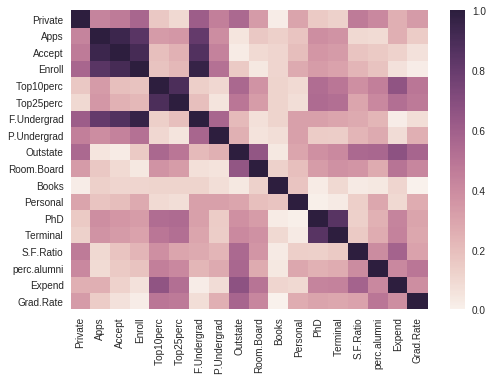

In [0]:
import seaborn as sns
sns.heatmap(col.corr().abs())

#### Compare and comment on the feature importances and corr() lists you have above.

Provide your observation and interpretation here.

Feature inportances list and correlation list show F.Undergrad is the highest. They are pretty consistent.